# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

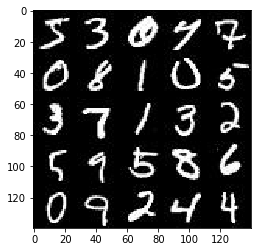

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

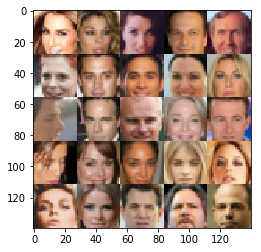

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/SG/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_img = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_image')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_img, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        activate_lrelu1 = tf.maximum(0.1*layer1, layer1)
        
        layer2 = tf.layers.conv2d(activate_lrelu1, 128, 5, strides=2, padding='same')
        batch_norm = tf.layers.batch_normalization(layer2, training=True)
        activate_lrelu2 = tf.maximum(0.1*batch_norm, batch_norm)
        
        layer3 = tf.layers.conv2d(activate_lrelu2, 256, 5, strides=1, padding='same')
        batch_norm2 = tf.layers.batch_normalization(layer3, training=True)
        activate_lrelu3 = tf.maximum(0.1*batch_norm2, batch_norm2)

        # Flatten
        flatten = tf.reshape(activate_lrelu3, (-1, 7*7*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        layer1 = tf.layers.dense(z, 7*7*512)
        # Reshape
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(0.1 * layer1, layer1)
        # 7x7x512 now
            
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(0.1 * layer2, layer2)
        # 14x14x256 now
    
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(0.1 * layer3, layer3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same')
        # Finally 28 now
    
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    samples, input_width, input_height, input_channels = data_shape
    input_Real, input_Z, lr = model_inputs(input_width, input_height, input_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_Real, input_Z, input_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
        
    samples, losses = [], []
    steps = 0
    
    saver = tf.train.Saver()


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2.0

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_Real: batch_images, input_Z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_Real: batch_images, input_Z: batch_z, lr: learning_rate})

                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_Z: batch_z, input_Real: batch_images})
                    train_loss_g = g_loss.eval({input_Z: batch_z, input_Real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_Z, input_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 8.0352
Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 1.1718
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.6307
Epoch 1/2... Discriminator Loss: 1.6925... Generator Loss: 2.3107
Epoch 1/2... Discriminator Loss: 1.9163... Generator Loss: 1.7698


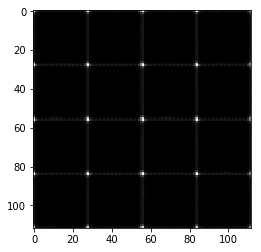

Epoch 1/2... Discriminator Loss: 1.5639... Generator Loss: 1.4017
Epoch 1/2... Discriminator Loss: 1.7496... Generator Loss: 1.6198
Epoch 1/2... Discriminator Loss: 1.7933... Generator Loss: 0.3366
Epoch 1/2... Discriminator Loss: 1.6965... Generator Loss: 1.7613
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 1.1768


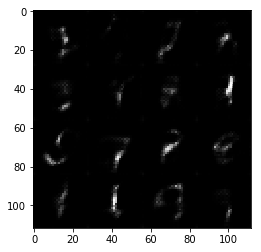

Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.8559
Epoch 1/2... Discriminator Loss: 1.5932... Generator Loss: 0.4240
Epoch 1/2... Discriminator Loss: 1.7365... Generator Loss: 0.3612
Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 0.5560
Epoch 1/2... Discriminator Loss: 1.7397... Generator Loss: 0.3399


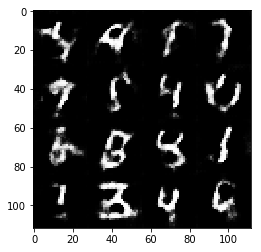

Epoch 1/2... Discriminator Loss: 1.7049... Generator Loss: 0.3571
Epoch 1/2... Discriminator Loss: 1.6267... Generator Loss: 1.8994
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.7707... Generator Loss: 0.3387


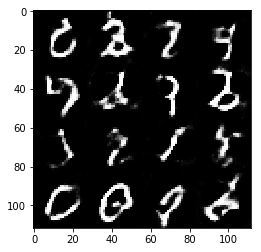

Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.4883
Epoch 1/2... Discriminator Loss: 1.1960... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 1.5008... Generator Loss: 0.4771
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 1.3138
Epoch 1/2... Discriminator Loss: 1.1685... Generator Loss: 1.3211


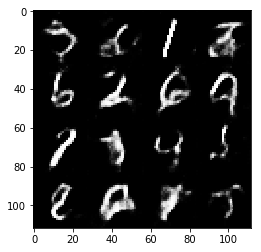

Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 1.9007
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 1.7881
Epoch 1/2... Discriminator Loss: 1.7032... Generator Loss: 0.3925
Epoch 1/2... Discriminator Loss: 1.2966... Generator Loss: 0.6719
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 0.7821


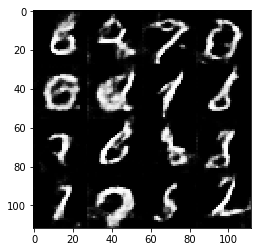

Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 1.7762
Epoch 1/2... Discriminator Loss: 1.6127... Generator Loss: 2.0737
Epoch 1/2... Discriminator Loss: 1.6586... Generator Loss: 0.4351
Epoch 1/2... Discriminator Loss: 1.4393... Generator Loss: 0.5324
Epoch 1/2... Discriminator Loss: 1.5050... Generator Loss: 0.4992


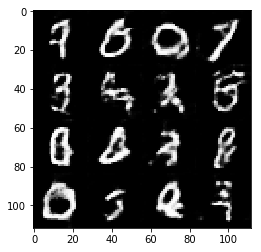

Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 1.2287... Generator Loss: 1.4838
Epoch 1/2... Discriminator Loss: 1.2088... Generator Loss: 1.2656
Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 1.0656
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 1.2587


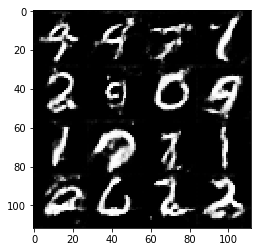

Epoch 1/2... Discriminator Loss: 1.5238... Generator Loss: 0.4520
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 1.6419
Epoch 1/2... Discriminator Loss: 1.8384... Generator Loss: 0.3235
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 1.8472
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 1.0744


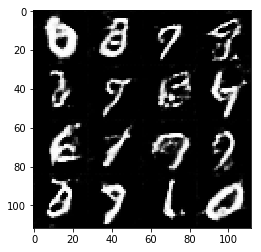

Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 1.5673
Epoch 2/2... Discriminator Loss: 1.4403... Generator Loss: 0.4851
Epoch 2/2... Discriminator Loss: 1.5669... Generator Loss: 0.4389
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.8440
Epoch 2/2... Discriminator Loss: 1.2937... Generator Loss: 1.3307


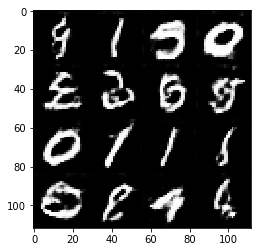

Epoch 2/2... Discriminator Loss: 1.4709... Generator Loss: 0.4813
Epoch 2/2... Discriminator Loss: 1.8345... Generator Loss: 0.3328
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 1.5477
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 1.7020
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.7338


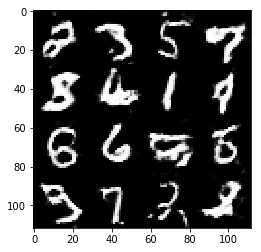

Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.1739... Generator Loss: 1.5897
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 1.2877... Generator Loss: 1.2392
Epoch 2/2... Discriminator Loss: 1.7179... Generator Loss: 0.3997


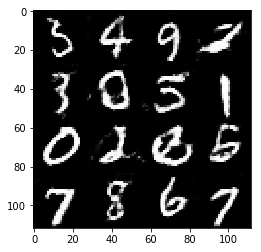

Epoch 2/2... Discriminator Loss: 1.0852... Generator Loss: 0.8935
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 1.5888... Generator Loss: 1.7854
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.7876
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 1.5345


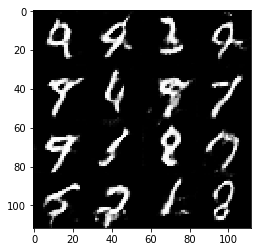

Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.9440
Epoch 2/2... Discriminator Loss: 1.1195... Generator Loss: 1.0857
Epoch 2/2... Discriminator Loss: 1.5346... Generator Loss: 0.4646
Epoch 2/2... Discriminator Loss: 1.0037... Generator Loss: 1.1211
Epoch 2/2... Discriminator Loss: 1.2385... Generator Loss: 1.4595


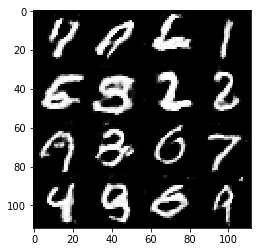

Epoch 2/2... Discriminator Loss: 1.5865... Generator Loss: 0.4088
Epoch 2/2... Discriminator Loss: 1.5379... Generator Loss: 0.4742
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.6755
Epoch 2/2... Discriminator Loss: 0.9798... Generator Loss: 1.6392


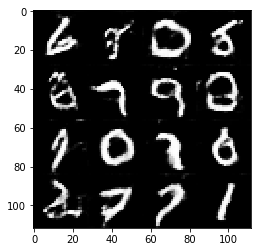

Epoch 2/2... Discriminator Loss: 0.9907... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 0.9296... Generator Loss: 1.2543
Epoch 2/2... Discriminator Loss: 1.6889... Generator Loss: 0.3480
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.6033
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.6478


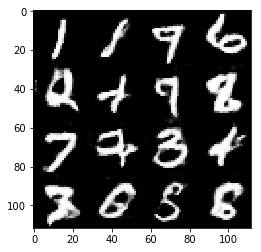

Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 1.4743
Epoch 2/2... Discriminator Loss: 1.8623... Generator Loss: 0.3235
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 0.6148
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 1.2109... Generator Loss: 0.7055


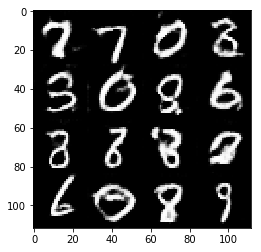

Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 0.6751
Epoch 2/2... Discriminator Loss: 1.0036... Generator Loss: 1.2422
Epoch 2/2... Discriminator Loss: 0.9778... Generator Loss: 1.5066
Epoch 2/2... Discriminator Loss: 1.4916... Generator Loss: 0.5592
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 1.2113


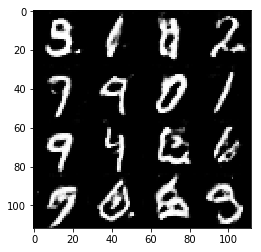

Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.7256
Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 1.3572
Epoch 2/2... Discriminator Loss: 1.5441... Generator Loss: 0.4773


In [17]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 10.4045
Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 11.8576
Epoch 1/1... Discriminator Loss: 3.2568... Generator Loss: 7.2839
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 2.4826
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 3.0913


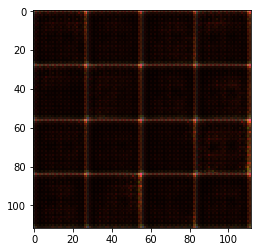

Epoch 1/1... Discriminator Loss: 0.4822... Generator Loss: 2.7703
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.6533


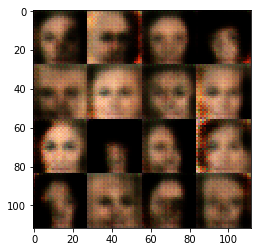

Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 1.7950... Generator Loss: 0.3186
Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7770


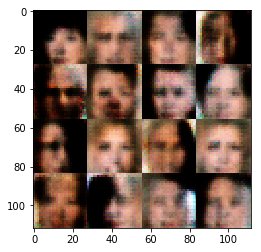

Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.6830... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.4865


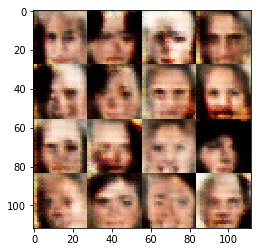

Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 1.4608
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 1.7622... Generator Loss: 2.4947
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 1.9760


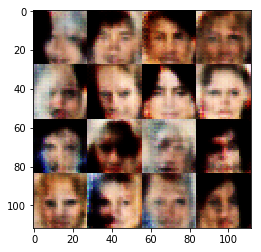

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.8301
Epoch 1/1... Discriminator Loss: 1.8632... Generator Loss: 0.2825
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 1.0282


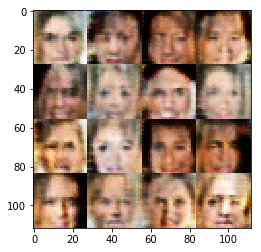

Epoch 1/1... Discriminator Loss: 1.8187... Generator Loss: 2.0009
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.7938
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 1.2593
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.8935


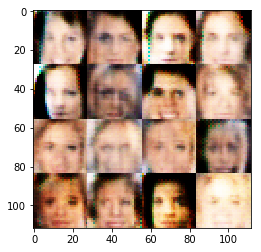

Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.6179
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6075


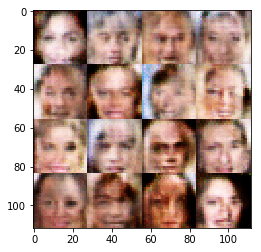

Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 0.8497


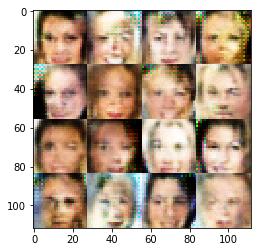

Epoch 1/1... Discriminator Loss: 1.7559... Generator Loss: 2.0825
Epoch 1/1... Discriminator Loss: 2.2789... Generator Loss: 2.0279
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 1.0173


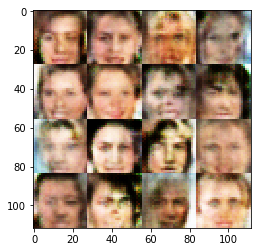

Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.7222


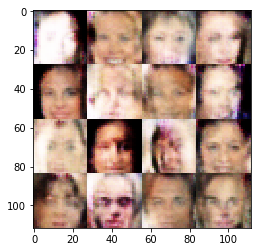

Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 1.6419
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 1.0753


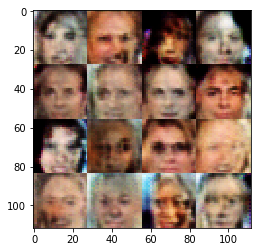

Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 1.8234... Generator Loss: 2.1213
Epoch 1/1... Discriminator Loss: 1.5828... Generator Loss: 0.3705
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 1.2603


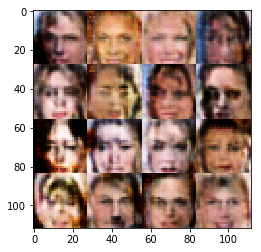

Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.4278
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.7391


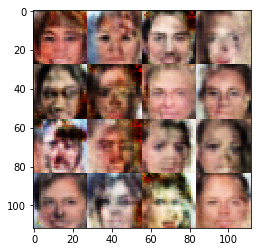

Epoch 1/1... Discriminator Loss: 3.6037... Generator Loss: 3.9522
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.3856
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.4715


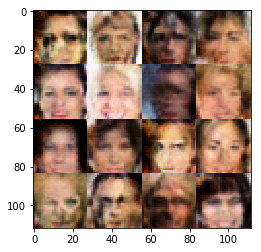

Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.5276
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.6905


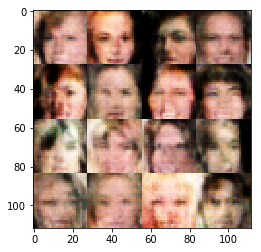

Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 1.6867
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.8856


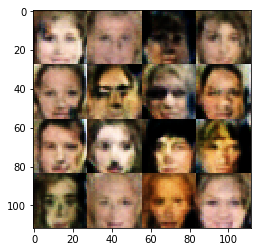

Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.9851... Generator Loss: 0.2586
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.1697


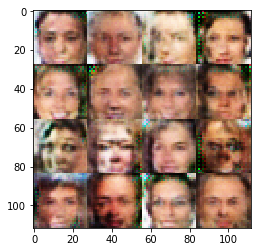

Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6399


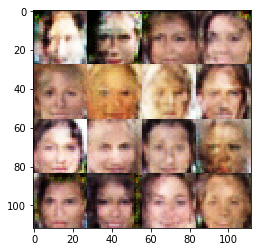

Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.6167


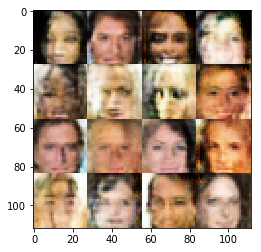

Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.9756


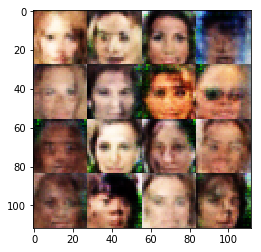

Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 1.5558


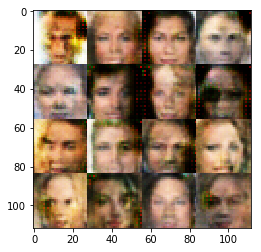

Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7844


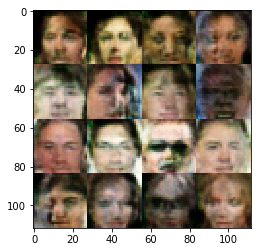

Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 2.1012... Generator Loss: 1.8296
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8096


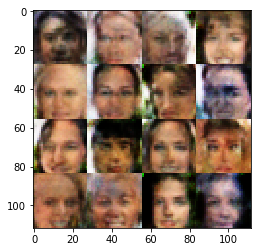

Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 1.7619
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.5582


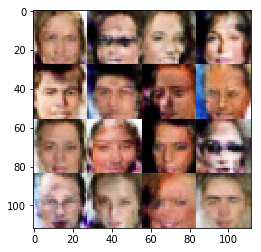

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 1.6685... Generator Loss: 2.0426
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.7687


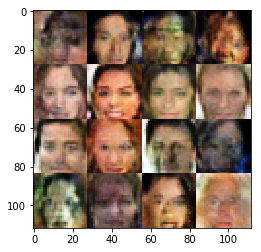

Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.9702


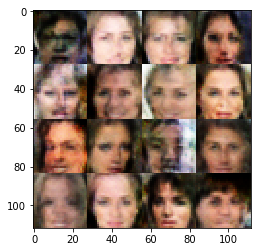

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 1.6881
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.6713


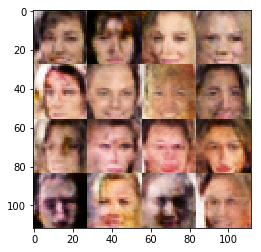

Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 1.0807
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 1.1081


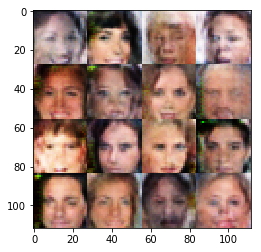

Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.6835


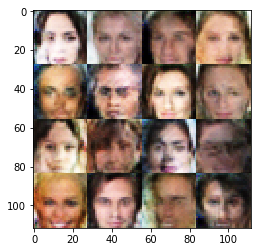

Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 2.2568... Generator Loss: 0.1906
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7563


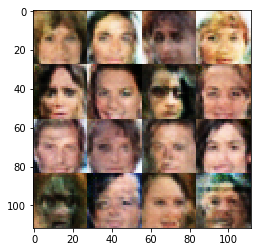

Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7914


In [18]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.